In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn")
from collections import Counter

Датает опроса разработчиков [Stack Overflow Developer Survey](https://www.kaggle.com/stackoverflow/so-survey-2017)

В датасете много данных о разработчиках, их жизни, зарплате и предпочтениях. 

154 столбца...
Потребуется отсечь не нужные данные

количество наблюдений, признаков, 
предметная область, содержание признаков, 
характер целевой переменной, задача обучения (регрессия, классификация, количество классов).

In [2]:
survey = pd.read_csv("./s_p.csv")
survey.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Начну с того, что погляжу какие столбцы мне могут пригодиться

In [3]:
np.array(survey.columns)

array(['Respondent', 'Professional', 'ProgramHobby', 'Country',
       'University', 'EmploymentStatus', 'FormalEducation',
       'MajorUndergrad', 'HomeRemote', 'CompanySize', 'CompanyType',
       'YearsProgram', 'YearsCodedJob', 'YearsCodedJobPast',
       'DeveloperType', 'WebDeveloperType', 'MobileDeveloperType',
       'NonDeveloperType', 'CareerSatisfaction', 'JobSatisfaction',
       'ExCoderReturn', 'ExCoderNotForMe', 'ExCoderBalance',
       'ExCoder10Years', 'ExCoderBelonged', 'ExCoderSkills',
       'ExCoderWillNotCode', 'ExCoderActive', 'PronounceGIF',
       'ProblemSolving', 'BuildingThings', 'LearningNewTech',
       'BoringDetails', 'JobSecurity', 'DiversityImportant', 'AnnoyingUI',
       'FriendsDevelopers', 'RightWrongWay', 'UnderstandComputers',
       'SeriousWork', 'InvestTimeTools', 'WorkPayCare',
       'KinshipDevelopers', 'ChallengeMyself', 'CompetePeers',
       'ChangeWorld', 'JobSeekingStatus', 'HoursPerWeek', 'LastNewJob',
       'AssessJobIndustry', 'As

Первым делом мне интересен контингент этого датасета

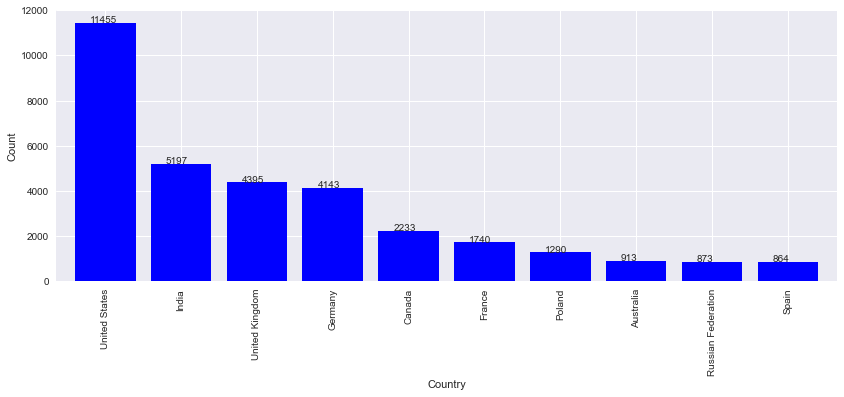

In [4]:
plt.subplots(figsize=(14, 5))
ax = survey["Country"].value_counts()[:10].plot.bar(width=0.8, color="blue")
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x() + 0.20, p.get_height()))
plt.xlabel("Country")
plt.ylabel("Count")
plt.show()

Тут я увидел Россию и подумал может получиться еще среди стран найти братьев наших меньших – СНГ и страны рядом

In [5]:
survey.Country.unique()

array(['United States', 'United Kingdom', 'Switzerland', 'New Zealand',
       'Poland', 'Colombia', 'France', 'Canada', 'Germany', 'Greece',
       'Brazil', 'Israel', 'Italy', 'Belgium', 'India', 'Chile',
       'Croatia', 'Argentina', 'Netherlands', 'Denmark', 'Ukraine',
       'Sri Lanka', 'Malaysia', 'Finland', 'Turkey', 'Spain', 'Austria',
       'Mexico', 'Russian Federation', 'Bulgaria', 'Uruguay', 'Estonia',
       'Iran', 'Bangladesh', 'Sweden', 'Lithuania', 'Paraguay', 'Romania',
       'Costa Rica', 'Serbia', 'Slovenia', 'United Arab Emirates',
       'Tunisia', 'Kenya', 'El Salvador', 'Norway', 'Dominican Republic',
       'Belarus', 'Portugal', 'Czech Republic', 'Albania',
       'I prefer not to say', 'South Africa', 'Uzbekistan', 'Moldavia',
       'Ireland', 'Nepal', 'Pakistan', 'Slovak Republic', 'Hungary',
       'Egypt', 'Australia', 'Japan', 'South Korea', 'Rwanda',
       'Luxembourg', 'Kazakhstan', 'Bolivia', 'Vietnam', 'Somalia',
       'Saudi Arabia', 'Ethiopia

In [6]:
sng = survey.query("Country in ('Russian Federation', 'Ukraine', 'Belarus', 'Kazakhstan', 'Armenia', 'Kyrgyzstan', 'Georgia', 'Turkey')")

Так как целевая переменная зарплата необходимо узнать сколько в целом данных о зарплате у нас есть

In [7]:
sng['Salary'].describe()

count       368.000000
mean      18652.903513
std       18088.708791
min          12.962963
25%        2172.096909
50%       14118.629908
75%       30075.187970
max      100000.000000
Name: Salary, dtype: float64

In [8]:
survey['Salary'].describe()

count     12891.000000
mean      56298.480641
std       39880.905277
min           0.000000
25%       26440.371839
50%       50000.000000
75%       80000.000000
max      197000.000000
Name: Salary, dtype: float64

Видно что у отобранных стран слишком мало данных. По этому буду использовать данные всех стран

Стало интересно много ли студентов

([<matplotlib.patches.Wedge at 0x15ef46c70>,
 [Text(0.9638958724607595, 0.5300044783330716, 'Student'),
  Text(-1.097105442234513, -0.07974740509517264, 'Professional developer'),
  Text(0.9399919365933658, -0.5713275410300593, 'Professional non-developer who sometimes writes code'),
  Text(1.08379964964392, -0.18809125293781442, 'Used to be a professional developer'),
  Text(1.0982834694602495, -0.06142817521591892, 'None of these')])

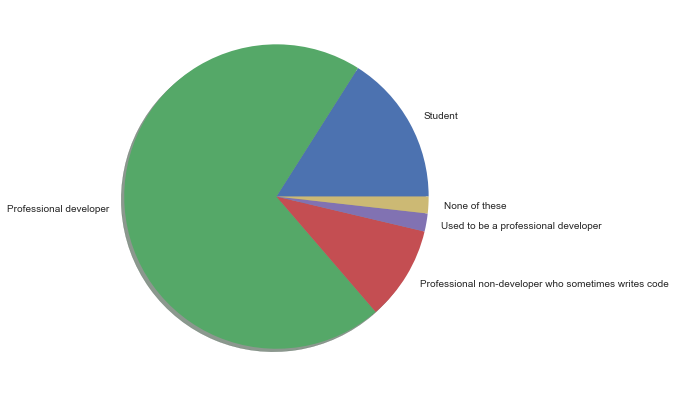

In [9]:
plt.subplots(figsize=(7, 7))
plt.pie(
    dict(Counter(survey.Professional)).values(),
    labels=dict(Counter(survey.Professional)).keys(),
    shadow=True,
    startangle=0,
)

Не особо. В основном примерно 3/4 это профессиональные разработчики

В этом датасете я хочу научиться предсказывать зарплату
Посмотрим данные по зарплатам + попробуем поделить людей по полу

In [10]:
survey['Salary'].describe()

count     12891.000000
mean      56298.480641
std       39880.905277
min           0.000000
25%       26440.371839
50%       50000.000000
75%       80000.000000
max      197000.000000
Name: Salary, dtype: float64

In [11]:
survey[survey['Gender']=='Female']['Salary'].describe()

count       819.000000
mean      58083.924534
std       38607.488222
min           0.000000
25%       31250.000000
50%       52500.000000
75%       83000.000000
max      195000.000000
Name: Salary, dtype: float64

In [12]:
survey[survey['Gender']=='Male']['Salary'].describe()

count     10666.000000
mean      56996.494293
std       39722.918323
min           0.000000
25%       27262.626263
50%       50537.634409
75%       80000.000000
max      197000.000000
Name: Salary, dtype: float64

По данным видно, что распределение данных в основном приходится на мужскую аудиторию.
Зарплаты отличаются в пределах нормы, но данные показывают, что программированием занимается в основном мужская аудитория

Очистим данные от строк без известной зарплаты

In [13]:
survey = survey[survey['Salary'].notna()]
survey.Salary.describe()

count     12891.000000
mean      56298.480641
std       39880.905277
min           0.000000
25%       26440.371839
50%       50000.000000
75%       80000.000000
max      197000.000000
Name: Salary, dtype: float64

In [14]:
survey['Salary']


2        113750.000000
14       100000.000000
17       130000.000000
18        82500.000000
22       100764.000000
             ...      
51371     74193.548387
51378    107526.881720
51382     32258.064516
51387     58000.000000
51390     40000.000000
Name: Salary, Length: 12891, dtype: float64

Отберем данные подходящие под мои требования к датасету и очистим

In [15]:
df = survey[['Salary',
              'Gender',
              'University',
              'WorkStart',
              'Professional',
              'ProgramHobby',
              'Country',
              'SeriousWork',
              'WorkPayCare',
              'ChangeWorld',
              'AnnoyingUI',
              'ProblemSolving',
              'LearningNewTech',
              'Currency',
              'JobSecurity']]
for i in ('WorkStart', 'Gender', 'LearningNewTech', 'ChangeWorld', 'ChangeWorld',
          'SeriousWork', 'WorkPayCare', 'AnnoyingUI', 'ProblemSolving', 'JobSecurity'):
    df = df[df[i].notna()]
df = pd.DataFrame(df)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


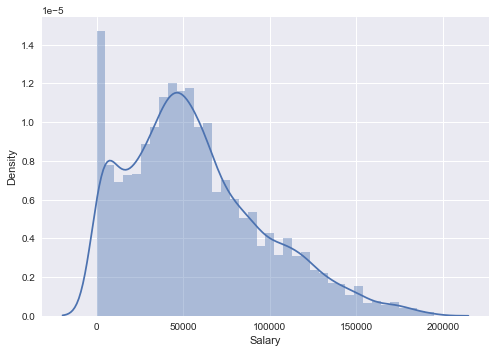

In [16]:
sns_plot = sns.distplot(df["Salary"])
fig = sns_plot.get_figure()

([<matplotlib.patches.Wedge at 0x161097df0>,
 [Text(1.0368829730018, 0.36725154907630897, 'British pounds sterling (£)'),
  Text(-0.18166634950477484, 1.0848950813132159, 'U.S. dollars ($)'),
  Text(-1.0531736936170144, 0.31752979556743227, 'Brazilian reais (R$)'),
  Text(-1.097833171468908, 0.06900961978245838, 'Indian rupees (?)'),
  Text(-0.6875141592143857, -0.8586758881439123, 'Euros (€)'),
  Text(0.20193846547506444, -1.0813051632918325, 'Polish zloty (zl)'),
  Text(0.5047133247337304, -0.97737631434173, 'nan'),
  Text(0.8302383700541559, -0.7215983986192173, 'Canadian dollars (C$)'),
  Text(0.961055209052823, -0.5351381925749971, 'Russian rubles (?)'),
  Text(1.0075455178377337, -0.44142046790457423, 'Swedish kroner (SEK)'),
  Text(1.0360209322739526, -0.3696763826513807, 'Mexican pesos (MXN$)'),
  Text(1.064858811856466, -0.2758182568497522, 'Australian dollars (A$)'),
  Text(1.0881364056569822, -0.16111847406149166, 'Swiss francs'),
  Text(1.0949844601615988, -0.10492393437444

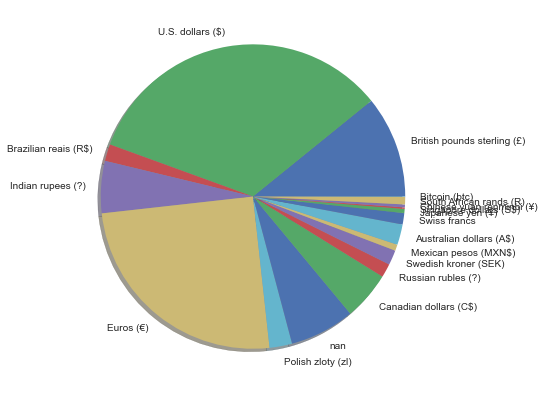

In [17]:
plt.subplots(figsize=(7, 7))
plt.pie(
    dict(Counter(df.Currency)).values(),
    labels=dict(Counter(df.Currency)).keys(),
    shadow=True,
    startangle=0,
)

Возьму самые крупные валюты и помножу на их курс

In [18]:
df = df.query("Currency in ('U.S. dollars ($)', 'Euros (€)', 'British pounds sterling (£)')")
df

,Salary,Gender,University,WorkStart,Professional,ProgramHobby,Country,SeriousWork,WorkPayCare,ChangeWorld,AnnoyingUI,ProblemSolving,LearningNewTech,Currency,JobSecurity
2,113750.000000,Male,No,9:00 AM,Professional developer,"Yes, both",United Kingdom,Agree,Disagree,Agree,Agree,Strongly agree,Strongly agree,British pounds sterling (£),Agree
14,100000.000000,Male,No,9:00 AM,Professional developer,"Yes, I program as a hobby",United Kingdom,Agree,Disagree,Somewhat agree,Strongly agree,Strongly agree,Agree,British pounds sterling (£),Somewhat agree
17,130000.000000,Male,"Yes, part-time",10:00 AM,Professional developer,"Yes, both",United States,Agree,Strongly disagree,Strongly agree,Agree,Strongly agree,Strongly agree,U.S. dollars ($),Agree
25,175000.000000,Male,No,8:00 AM,Professional developer,"Yes, I program as a hobby",United States,Strongly agree,Disagree,Somewhat agree,Strongly agree,Agree,Strongly agree,U.S. dollars ($),Agree
36,28200.000000,Male,No,10:00 AM,Professional developer,"Yes, I program as a hobby",Argentina,Agree,Strongly disagree,Agree,Strongly agree,Strongly agree,Strongly agree,U.S. dollars ($),Agree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51371,74193.548387,Male,No,10:00 AM,Professional developer,No,Netherlands,Agree,Disagree,Strongly agree,Agree,Agree,Agree,Euros (€),Agree
51378,107526.881720,Male,No,10:00 AM,Professional developer,"Yes, I contribute to open source projects",Cyprus,Agree,Strongly disagree,Strongly agree,Strongly agree,Strongly agree,Somewhat agree,Euros (€),Agree
51382,32258.064516,Male,No,9:00 AM,Professional developer,"Yes, I program as a hobby",France,Strongly agree,Strongly disagree,Agree,Strongly agree,Strongly agree,Agree,Euros (€),Agree
51387,58000.000000,Male,No,9:00 AM,Professional developer,"Yes, I program as a hobby",United States,Agree,Somewhat agree,Somewhat agree,Agree,Strongly agree,Strongly agree,U.S. dollars ($),Strongly agree


In [19]:
df.Salary[df.Currency == "Euros (€)"] = df.Salary[df.Currency == "Euros (€)"] * 1.19
df.Salary[df.Currency == "British pounds sterling (£)"] = (
    df.Salary[df.Currency == "British pounds sterling (£)"] * 1.33
)
df = df[(df.Salary > 10000)]
df.drop(columns=["Currency", "Professional"], inplace=True)
df

<ipython-input-19-a43aa4e6dac9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Salary[df.Currency == "British pounds sterling (£)"] = (
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Salary,Gender,University,WorkStart,ProgramHobby,Country,SeriousWork,WorkPayCare,ChangeWorld,AnnoyingUI,ProblemSolving,LearningNewTech,JobSecurity
2,151287.500000,Male,No,9:00 AM,"Yes, both",United Kingdom,Agree,Disagree,Agree,Agree,Strongly agree,Strongly agree,Agree
14,133000.000000,Male,No,9:00 AM,"Yes, I program as a hobby",United Kingdom,Agree,Disagree,Somewhat agree,Strongly agree,Strongly agree,Agree,Somewhat agree
17,130000.000000,Male,"Yes, part-time",10:00 AM,"Yes, both",United States,Agree,Strongly disagree,Strongly agree,Agree,Strongly agree,Strongly agree,Agree
25,175000.000000,Male,No,8:00 AM,"Yes, I program as a hobby",United States,Strongly agree,Disagree,Somewhat agree,Strongly agree,Agree,Strongly agree,Agree
36,28200.000000,Male,No,10:00 AM,"Yes, I program as a hobby",Argentina,Agree,Strongly disagree,Agree,Strongly agree,Strongly agree,Strongly agree,Agree
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51371,88290.322581,Male,No,10:00 AM,No,Netherlands,Agree,Disagree,Strongly agree,Agree,Agree,Agree,Agree
51378,127956.989247,Male,No,10:00 AM,"Yes, I contribute to open source projects",Cyprus,Agree,Strongly disagree,Strongly agree,Strongly agree,Strongly agree,Somewhat agree,Agree
51382,38387.096774,Male,No,9:00 AM,"Yes, I program as a hobby",France,Strongly agree,Strongly disagree,Agree,Strongly agree,Strongly agree,Agree,Agree
51387,58000.000000,Male,No,9:00 AM,"Yes, I program as a hobby",United States,Agree,Somewhat agree,Somewhat agree,Agree,Strongly agree,Strongly agree,Strongly agree


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


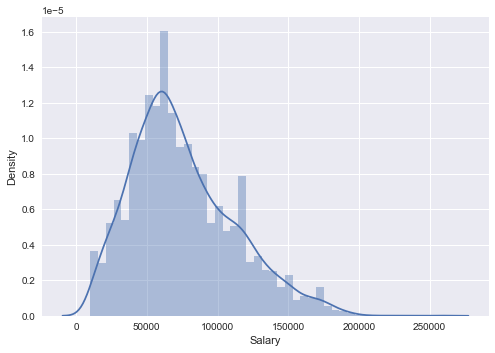

In [20]:
sns_plot = sns.distplot(df["Salary"])
fig = sns_plot.get_figure()

In [21]:
df.isna().sum()


Salary             0
Gender             0
University         0
WorkStart          0
ProgramHobby       0
Country            0
SeriousWork        0
WorkPayCare        0
ChangeWorld        0
AnnoyingUI         0
ProblemSolving     0
LearningNewTech    0
JobSecurity        0
dtype: int64

In [22]:
df[["SeriousWork"]] = df[["SeriousWork"]].apply(lambda col: pd.Categorical(col).codes)
df[["WorkPayCare"]] = df[["WorkPayCare"]].apply(lambda col: pd.Categorical(col).codes)
df

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Salary,Gender,University,WorkStart,ProgramHobby,Country,SeriousWork,WorkPayCare,ChangeWorld,AnnoyingUI,ProblemSolving,LearningNewTech,JobSecurity
2,151287.500000,Male,No,9:00 AM,"Yes, both",United Kingdom,0,1,Agree,Agree,Strongly agree,Strongly agree,Agree
14,133000.000000,Male,No,9:00 AM,"Yes, I program as a hobby",United Kingdom,0,1,Somewhat agree,Strongly agree,Strongly agree,Agree,Somewhat agree
17,130000.000000,Male,"Yes, part-time",10:00 AM,"Yes, both",United States,0,4,Strongly agree,Agree,Strongly agree,Strongly agree,Agree
25,175000.000000,Male,No,8:00 AM,"Yes, I program as a hobby",United States,3,1,Somewhat agree,Strongly agree,Agree,Strongly agree,Agree
36,28200.000000,Male,No,10:00 AM,"Yes, I program as a hobby",Argentina,0,4,Agree,Strongly agree,Strongly agree,Strongly agree,Agree
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51371,88290.322581,Male,No,10:00 AM,No,Netherlands,0,1,Strongly agree,Agree,Agree,Agree,Agree
51378,127956.989247,Male,No,10:00 AM,"Yes, I contribute to open source projects",Cyprus,0,4,Strongly agree,Strongly agree,Strongly agree,Somewhat agree,Agree
51382,38387.096774,Male,No,9:00 AM,"Yes, I program as a hobby",France,3,4,Agree,Strongly agree,Strongly agree,Agree,Agree
51387,58000.000000,Male,No,9:00 AM,"Yes, I program as a hobby",United States,0,2,Somewhat agree,Agree,Strongly agree,Strongly agree,Strongly agree


In [23]:
df = pd.get_dummies(df, columns=['Gender',
                                  'University',
                                  'WorkStart',
                                  'ProgramHobby',
                                  'Country',
                                  'AnnoyingUI',
                                  'ChangeWorld',
                                  'ProblemSolving',
                                  'LearningNewTech',
                                  'JobSecurity'])

In [24]:
X = df[df.columns.difference(["Salary"])]
Y = df["Salary"]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.33, random_state=42
)

In [26]:
reg = RandomForestRegressor()
param_grid = {
    "n_estimators": [50, 100, 150, 200],
    "criterion": ["mse", "mae"],
    "max_depth": [2, 3, 5, 7, 9],
    "max_features": ["auto", "sqrt", "log2"],
}

In [27]:
# GSCV_reg = GridSearchCV(reg, param_grid,  n_jobs=-1, cv=3, verbose=1)
# GSCV_reg.fit(X_train, y_train)

In [28]:
# GSCV_reg.cv_results_

In [29]:
# GSCV_reg.best_params_
# {'criterion': 'mae',
#  'max_depth': 9,
#  'max_features': 'auto',
#  'n_estimators': 100}

In [30]:
reg = RandomForestRegressor(criterion='mae', max_depth=12, max_features='auto', n_estimators=150, n_jobs=-1)
reg.fit(X_train, y_train)

RandomForestRegressor(criterion='mae', max_depth=12, n_estimators=150,
                      n_jobs=-1)

In [31]:
print(reg.score(X_train, y_train))

0.6711099604203574


In [32]:
predicted = reg.predict(X_test)
print(reg.score(X_test, y_test))

0.35560281669356486


In [33]:
reg.feature_importances_[:10]

array([0.01682423, 0.00878284, 0.0145587 , 0.01450868, 0.00177739,
       0.01523252, 0.01686338, 0.01654803, 0.0163041 , 0.005703  ])

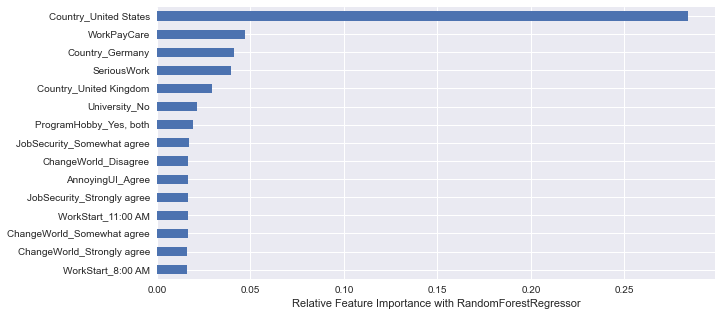

In [34]:
feat_importances = pd.Series(reg.feature_importances_, index=X.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', figsize=(10,5))
plt.xlabel('Relative Feature Importance with RandomForestRegressor');

In [35]:
feat_importances.nlargest(15).sort_values()

WorkStart_8:00 AM             0.015989
ChangeWorld_Strongly agree    0.016304
ChangeWorld_Somewhat agree    0.016548
WorkStart_11:00 AM            0.016676
JobSecurity_Strongly agree    0.016707
AnnoyingUI_Agree              0.016824
ChangeWorld_Disagree          0.016863
JobSecurity_Somewhat agree    0.017063
ProgramHobby_Yes, both        0.019260
University_No                 0.021726
Country_United Kingdom        0.029742
SeriousWork                   0.039651
Country_Germany               0.041533
WorkPayCare                   0.046927
Country_United States         0.284160
dtype: float64

In [36]:
new_df = df[['AnnoyingUI_Agree', 'ProgramHobby_Yes, I contribute to open source projects', 'ChangeWorld_Strongly agree',
            'ChangeWorld_Disagree', 'University_Yes, full-time', 'JobSecurity_Strongly agree', 'JobSecurity_Somewhat agree',
            'WorkStart_11:00 AM', 'ProgramHobby_Yes, both', 'University_No', 'WorkPayCare', 'SeriousWork',
            'Country_United Kingdom', 'Country_Germany', 'Country_United States']]
new_df.head()

,AnnoyingUI_Agree,"ProgramHobby_Yes, I contribute to open source projects",ChangeWorld_Strongly agree,ChangeWorld_Disagree,"University_Yes, full-time",JobSecurity_Strongly agree,JobSecurity_Somewhat agree,WorkStart_11:00 AM,"ProgramHobby_Yes, both",University_No,WorkPayCare,SeriousWork,Country_United Kingdom,Country_Germany,Country_United States
2,1,0,0,0,0,0,0,0,1,1,1,0,1,0,0
14,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0
17,1,0,1,0,0,0,0,0,1,0,4,0,0,0,1
25,0,0,0,0,0,0,0,0,0,1,1,3,0,0,1
36,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0


In [37]:
# reg = RandomForestRegressor()
# param_grid = {
#     "n_estimators": [50, 100, 150, 200],
#     "criterion": ["mse", "mae"],
#     "max_depth": [2, 3, 5, 7, 9],
#     "max_features": ["auto", "sqrt", "log2"],
# }

# X = new_df[new_df.columns.difference(["Salary"])]
# Y = new_df["Salary"]

# X_train, X_test, y_train, y_test = train_test_split(
#     X, Y, test_size=0.33, random_state=42
# )

# GSCV_reg = GridSearchCV(reg, param_grid, n_jobs=-1, cv=3, verbose=1)
# GSCV_reg.fit(X_train, y_train)

In [38]:
# GSCV_reg.best_params_

In [39]:
reg = RandomForestRegressor(criterion='mse', max_depth=5, max_features='auto', n_estimators=150, n_jobs=-1)
reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=150, n_jobs=-1)

In [40]:
print(reg.score(X_train, y_train))

0.4227248643284194


In [41]:
predicted = reg.predict(X_test)
print(reg.score(X_test, y_test))

0.3629570946975367


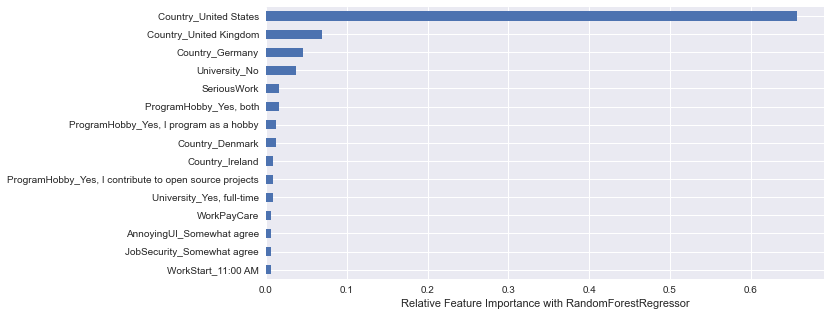

In [42]:
feat_importances = pd.Series(reg.feature_importances_, index=X.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', figsize=(10,5))
plt.xlabel('Relative Feature Importance with RandomForestRegressor');

XGBoost

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

x = XGBRegressor(random_state=44, n_jobs=-1, n_estimators=50, max_depth=12)
x.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=12,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=-1, num_parallel_tree=1, random_state=44,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [44]:
print("xgboost train score: ", x.score(X_train, y_train))
print("xgboost test score: ", x.score(X_test, y_test))

xgboost train score:  0.8562044154842492
xgboost test score:  0.263861124723319


PCA

In [45]:
pca = PCA(n_components=len(new_df.columns) - 5)
new_features = pca.fit_transform(
    StandardScaler().fit_transform(pd.concat([new_df], axis=1))
)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.11754859 0.10270499 0.09207182 0.08715347 0.07599056 0.07536543
 0.06824603 0.06542356 0.0619197  0.05797658]
[97.08873148 90.7519339  85.92577937 83.59926414 78.06204657 77.7402998
 73.97735403 72.43145411 70.46517209 68.18461658]


In [46]:
X_train, X_test, y_train, y_test = train_test_split(new_features, Y, test_size=0.33, random_state=42)

In [47]:
reg = RandomForestRegressor(criterion='mse', max_depth=24, max_features='auto', n_estimators=100, n_jobs=-1)
reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=24, n_jobs=-1)

In [48]:
print("train score: ", reg.score(X_train, y_train))
print("test score: ", reg.score(X_test, y_test))

train score:  0.6270489095354839
test score:  0.27023495003839504


PCA without Scaler + XGBoost

Your rationale is indeed correct: decision trees do not require normalization of their inputs; and since XGBoost is essentially an ensemble algorithm comprised of decision trees, it does not require normalization for the inputs either.

For corroboration, see also the thread Is Normalization necessary? at the XGBoost Github repo, where the answer by the lead XGBoost developer is a clear: https://github.com/dmlc/xgboost/issues/357

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    PCA(n_components=len(new_df.columns) - 5).fit_transform(pd.concat([new_df], axis=1)),
    Y,
    test_size=0.33,
    random_state=42
)

In [50]:
x2 = XGBRegressor(random_state=41, n_jobs=-1, n_estimators=100, max_depth=12)
x2.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=12,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=41,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:
print("xgboost train score: ", x2.score(X_train, y_train))
print("xgboost test score: ", x2.score(X_test, y_test))

xgboost train score:  0.657654621321809
xgboost test score:  0.19529702927454784


In [52]:
pd.DataFrame(
    [
        [
            "Train score",
            0.6717140119724982,
            0.8562044154842492,
            0.6276344785183754,
            0.6576602598197608,
        ],
        [
            "Test score",
            0.35524462390164824,
            0.26386112472331913,
            0.27162800439579005,
            0.2021774351370318,
        ],
    ],
    columns=[
        "",
        "Random Forest",
        "XGBoost",
        "PCA + Scaler",
        "PCA without Scaler + XGBoost",
    ],
)

,,Random Forest,XGBoost,PCA + Scaler,PCA without Scaler + XGBoost
0,Train score,0.671714,0.856204,0.627634,0.657660
1,Test score,0.355245,0.263861,0.271628,0.202177


Catboost

In [53]:
from catboost import CatBoostRegressor

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

model = CatBoostRegressor(iterations=666,
                          learning_rate=1,
                          depth=1)
model.fit(X_train, y_train)

0:	learn: 30718.9748956	total: 52.5ms	remaining: 34.9s
1:	learn: 30181.8763059	total: 53.8ms	remaining: 17.9s
2:	learn: 29701.4723526	total: 55.1ms	remaining: 12.2s
3:	learn: 29439.2030450	total: 56.4ms	remaining: 9.33s
4:	learn: 29225.9429814	total: 57.7ms	remaining: 7.63s
5:	learn: 29129.1505612	total: 59ms	remaining: 6.49s
6:	learn: 28975.4506619	total: 60.2ms	remaining: 5.67s
7:	learn: 28919.3034521	total: 61.5ms	remaining: 5.06s
8:	learn: 28835.3391381	total: 62.7ms	remaining: 4.58s
9:	learn: 28797.4566927	total: 63.9ms	remaining: 4.19s
10:	learn: 28696.2987828	total: 65.1ms	remaining: 3.88s
11:	learn: 28628.2688027	total: 66.4ms	remaining: 3.62s
12:	learn: 28571.1942691	total: 67.6ms	remaining: 3.4s
13:	learn: 28508.4107148	total: 68.8ms	remaining: 3.21s
14:	learn: 28433.3250739	total: 70ms	remaining: 3.04s
15:	learn: 28358.9979710	total: 71.2ms	remaining: 2.89s
16:	learn: 28306.0437149	total: 72.6ms	remaining: 2.77s
17:	learn: 28284.5301924	total: 73.9ms	remaining: 2.66s
18:	lea

213:	learn: 27112.7317118	total: 229ms	remaining: 484ms
214:	learn: 27111.9464428	total: 230ms	remaining: 483ms
215:	learn: 27110.7269445	total: 232ms	remaining: 483ms
216:	learn: 27110.6993439	total: 233ms	remaining: 483ms
217:	learn: 27109.6399522	total: 235ms	remaining: 482ms
218:	learn: 27108.7811774	total: 236ms	remaining: 482ms
219:	learn: 27108.2303217	total: 237ms	remaining: 480ms
220:	learn: 27107.4438885	total: 238ms	remaining: 479ms
221:	learn: 27107.0152449	total: 239ms	remaining: 478ms
222:	learn: 27106.1479247	total: 240ms	remaining: 477ms
223:	learn: 27105.4253867	total: 241ms	remaining: 476ms
224:	learn: 27104.7003739	total: 242ms	remaining: 475ms
225:	learn: 27104.3318232	total: 243ms	remaining: 474ms
226:	learn: 27104.0895894	total: 244ms	remaining: 472ms
227:	learn: 27103.7446626	total: 245ms	remaining: 471ms
228:	learn: 27103.1914984	total: 246ms	remaining: 470ms
229:	learn: 27102.0330504	total: 247ms	remaining: 469ms
230:	learn: 27101.1280449	total: 249ms	remaining

426:	learn: 27057.0114676	total: 408ms	remaining: 228ms
427:	learn: 27057.0113756	total: 409ms	remaining: 227ms
428:	learn: 27056.7940987	total: 410ms	remaining: 226ms
429:	learn: 27056.7928766	total: 411ms	remaining: 226ms
430:	learn: 27056.7904211	total: 412ms	remaining: 225ms
431:	learn: 27056.5390442	total: 413ms	remaining: 224ms
432:	learn: 27056.2933056	total: 414ms	remaining: 223ms
433:	learn: 27056.2924949	total: 415ms	remaining: 222ms
434:	learn: 27056.2923333	total: 417ms	remaining: 221ms
435:	learn: 27056.2923087	total: 418ms	remaining: 220ms
436:	learn: 27056.2910371	total: 419ms	remaining: 219ms
437:	learn: 27056.0431374	total: 419ms	remaining: 218ms
438:	learn: 27056.0424115	total: 420ms	remaining: 217ms
439:	learn: 27055.7952407	total: 421ms	remaining: 216ms
440:	learn: 27055.7950393	total: 422ms	remaining: 215ms
441:	learn: 27055.4633563	total: 423ms	remaining: 214ms
442:	learn: 27055.4632286	total: 424ms	remaining: 214ms
443:	learn: 27055.4632110	total: 425ms	remaining

In [54]:
print("catboost train score: ", model.score(X_train, y_train))
print("catboost test score: ", model.score(X_test, y_test))

catboost train score:  0.44170719211983067
catboost test score:  0.3892140603055001


Catboost + PCA

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    PCA(n_components=(len(new_df.columns)) - 10).fit_transform(pd.concat([new_df], axis=1)),
    Y,
    test_size=0.33,
    random_state=42
)

In [56]:
model = CatBoostRegressor(iterations=666,
                          learning_rate=1,
                          depth=1)
model.fit(X_train, y_train)

0:	learn: 30972.4820661	total: 2.35ms	remaining: 1.56s
1:	learn: 30770.3049720	total: 3.79ms	remaining: 1.26s
2:	learn: 30695.6345897	total: 5.59ms	remaining: 1.24s
3:	learn: 30623.4028223	total: 7.05ms	remaining: 1.17s
4:	learn: 30575.0103049	total: 8.19ms	remaining: 1.08s
5:	learn: 30532.7313365	total: 9.23ms	remaining: 1.01s
6:	learn: 30483.7578852	total: 10.3ms	remaining: 969ms
7:	learn: 30425.4543721	total: 11.3ms	remaining: 933ms
8:	learn: 30382.1050122	total: 12.6ms	remaining: 923ms
9:	learn: 30346.5499252	total: 14ms	remaining: 916ms
10:	learn: 30332.7047603	total: 15.4ms	remaining: 915ms
11:	learn: 30316.3327266	total: 16.8ms	remaining: 917ms
12:	learn: 30300.2444688	total: 18ms	remaining: 906ms
13:	learn: 30283.0331049	total: 19ms	remaining: 887ms
14:	learn: 30260.9854441	total: 20ms	remaining: 869ms
15:	learn: 30248.0356741	total: 21.1ms	remaining: 858ms
16:	learn: 30221.2838575	total: 22.2ms	remaining: 848ms
17:	learn: 30203.5111457	total: 23.1ms	remaining: 831ms
18:	learn:

183:	learn: 29321.8813727	total: 136ms	remaining: 356ms
184:	learn: 29319.6674068	total: 137ms	remaining: 356ms
185:	learn: 29317.2558867	total: 138ms	remaining: 356ms
186:	learn: 29314.0454241	total: 139ms	remaining: 356ms
187:	learn: 29312.0686622	total: 140ms	remaining: 357ms
188:	learn: 29309.9179988	total: 141ms	remaining: 356ms
189:	learn: 29308.2229080	total: 142ms	remaining: 356ms
190:	learn: 29305.9993076	total: 143ms	remaining: 357ms
191:	learn: 29304.3778073	total: 144ms	remaining: 356ms
192:	learn: 29302.4312437	total: 145ms	remaining: 356ms
193:	learn: 29299.4871787	total: 146ms	remaining: 356ms
194:	learn: 29297.2017464	total: 147ms	remaining: 355ms
195:	learn: 29294.2765297	total: 148ms	remaining: 355ms
196:	learn: 29290.6981931	total: 149ms	remaining: 355ms
197:	learn: 29287.6469036	total: 150ms	remaining: 355ms
198:	learn: 29284.6715728	total: 151ms	remaining: 355ms
199:	learn: 29283.1353445	total: 152ms	remaining: 354ms
200:	learn: 29280.8163911	total: 153ms	remaining

446:	learn: 28879.6022896	total: 310ms	remaining: 152ms
447:	learn: 28878.6982155	total: 311ms	remaining: 151ms
448:	learn: 28876.9529337	total: 312ms	remaining: 151ms
449:	learn: 28875.2046799	total: 313ms	remaining: 150ms
450:	learn: 28873.9787386	total: 314ms	remaining: 150ms
451:	learn: 28872.6431027	total: 315ms	remaining: 149ms
452:	learn: 28871.9426037	total: 316ms	remaining: 149ms
453:	learn: 28870.9964088	total: 317ms	remaining: 148ms
454:	learn: 28870.1833705	total: 318ms	remaining: 147ms
455:	learn: 28869.3247426	total: 319ms	remaining: 147ms
456:	learn: 28868.7388221	total: 320ms	remaining: 146ms
457:	learn: 28867.7291085	total: 321ms	remaining: 146ms
458:	learn: 28866.5500692	total: 321ms	remaining: 145ms
459:	learn: 28865.4548582	total: 323ms	remaining: 144ms
460:	learn: 28864.3592204	total: 323ms	remaining: 144ms
461:	learn: 28863.2542019	total: 324ms	remaining: 143ms
462:	learn: 28862.0652578	total: 325ms	remaining: 143ms
463:	learn: 28861.3026169	total: 326ms	remaining

In [57]:
print("catboost + pca train score: ", model.score(X_train, y_train))
print("catboost + pca test score: ", model.score(X_test, y_test))

catboost + pca train score:  0.3732395833964861
catboost + pca test score:  0.28049789115369606


Catboost + GridSearch

In [58]:
model = CatBoostRegressor()

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.33, random_state=42
)

grid = {
    "learning_rate": [0.03, 0.05, 0.1, 0.3, 0.33, 0.35, 0.37, 0.4, 0.5],
    "depth": [1, 2, 3, 4],
    "l2_leaf_reg": [1, 2, 3, 4, 5],
}

grid_search_result = model.grid_search(grid, X=X_train, y=y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 28301.54682
bestIteration = 990

0:	loss: 28301.5468202	best: 28301.5468202 (0)	total: 898ms	remaining: 2m 40s

bestTest = 28205.34237
bestIteration = 990

1:	loss: 28205.3423724	best: 28205.3423724 (1)	total: 1.58s	remaining: 2m 20s

bestTest = 28178.25494
bestIteration = 554

2:	loss: 28178.2549380	best: 28178.2549380 (2)	total: 2.26s	remaining: 2m 13s

bestTest = 28121.45603
bestIteration = 172

3:	loss: 28121.4560317	best: 28121.4560317 (3)	total: 2.85s	remaining: 2m 5s

bestTest = 28139.65426
bestIteration = 168

4:	loss: 28139.6542575	best: 28121.4560317 (3)	total: 3.57s	remaining: 2m 4s

bestTest = 28120.54335
bestIteration = 122

5:	loss: 28120.5433487	best: 28120.5433487 (5)	total: 4.17s	remaining: 2m 1s

bestTest = 28122.30427
bestIteration = 104

6:	loss: 28122.3042668	best: 28120.5433487 (5)	total: 4.82s	remaining: 1m 59s

bestTest = 28087.23002
bestIteration = 107

7:	loss: 28087.2300179	best: 28087.2300179 (7)	total: 5.43s	remaining: 1m 56s

bestTest = 28116.3


bestTest = 28150.98009
bestIteration = 110

67:	loss: 28150.9800918	best: 28020.7607236 (53)	total: 50.8s	remaining: 1m 23s

bestTest = 28092.49814
bestIteration = 130

68:	loss: 28092.4981374	best: 28020.7607236 (53)	total: 51.7s	remaining: 1m 23s

bestTest = 28205.1605
bestIteration = 107

69:	loss: 28205.1605038	best: 28020.7607236 (53)	total: 52.5s	remaining: 1m 22s

bestTest = 28236.5125
bestIteration = 82

70:	loss: 28236.5124962	best: 28020.7607236 (53)	total: 53.4s	remaining: 1m 21s

bestTest = 27978.09051
bestIteration = 102

71:	loss: 27978.0905104	best: 27978.0905104 (71)	total: 54.3s	remaining: 1m 21s

bestTest = 28155.09877
bestIteration = 992

72:	loss: 28155.0987688	best: 27978.0905104 (71)	total: 55.1s	remaining: 1m 20s

bestTest = 28079.41901
bestIteration = 940

73:	loss: 28079.4190136	best: 27978.0905104 (71)	total: 56s	remaining: 1m 20s

bestTest = 28137.03085
bestIteration = 582

74:	loss: 28137.0308546	best: 27978.0905104 (71)	total: 56.9s	remaining: 1m 19s

best


bestTest = 28154.51598
bestIteration = 57

133:	loss: 28154.5159844	best: 27942.4493937 (93)	total: 2m	remaining: 41.4s

bestTest = 28217.06701
bestIteration = 60

134:	loss: 28217.0670140	best: 27942.4493937 (93)	total: 2m 1s	remaining: 40.6s

bestTest = 28128.21973
bestIteration = 475

135:	loss: 28128.2197291	best: 27942.4493937 (93)	total: 2m 3s	remaining: 39.8s

bestTest = 28096.46896
bestIteration = 280

136:	loss: 28096.4689576	best: 27942.4493937 (93)	total: 2m 4s	remaining: 39s

bestTest = 28113.40303
bestIteration = 157

137:	loss: 28113.4030268	best: 27942.4493937 (93)	total: 2m 5s	remaining: 38.3s

bestTest = 28190.84709
bestIteration = 66

138:	loss: 28190.8470935	best: 27942.4493937 (93)	total: 2m 7s	remaining: 37.5s

bestTest = 28122.20608
bestIteration = 55

139:	loss: 28122.2060800	best: 27942.4493937 (93)	total: 2m 8s	remaining: 36.7s

bestTest = 28046.00617
bestIteration = 48

140:	loss: 28046.0061690	best: 27942.4493937 (93)	total: 2m 9s	remaining: 35.9s

bestTest 

In [59]:
grid_search_result

{'params': {'depth': 3, 'l2_leaf_reg': 1, 'learning_rate': 0.3},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
     

In [60]:
model = CatBoostRegressor(iterations=210, **{'depth': 2, 'l2_leaf_reg': 3, 'learning_rate': 0.38})
model.fit(X_train, y_train)

0:	learn: 32929.3438085	total: 1.94ms	remaining: 405ms
1:	learn: 31239.6350609	total: 3.13ms	remaining: 326ms
2:	learn: 30337.5275959	total: 4.11ms	remaining: 283ms
3:	learn: 29988.2893955	total: 5.39ms	remaining: 278ms
4:	learn: 29864.1836853	total: 6.27ms	remaining: 257ms
5:	learn: 29671.2890632	total: 7.18ms	remaining: 244ms
6:	learn: 29539.6872339	total: 8.17ms	remaining: 237ms
7:	learn: 29444.4662569	total: 9.73ms	remaining: 246ms
8:	learn: 29285.5158312	total: 10.9ms	remaining: 242ms
9:	learn: 29207.4980814	total: 11.6ms	remaining: 232ms
10:	learn: 29139.6850756	total: 13.5ms	remaining: 243ms
11:	learn: 29034.2006214	total: 15.2ms	remaining: 251ms
12:	learn: 29011.7942156	total: 16.9ms	remaining: 255ms
13:	learn: 28955.0961324	total: 18.7ms	remaining: 261ms
14:	learn: 28827.4821734	total: 20ms	remaining: 260ms
15:	learn: 28768.7256476	total: 21.8ms	remaining: 264ms
16:	learn: 28705.0176269	total: 23.7ms	remaining: 269ms
17:	learn: 28655.5231032	total: 25.4ms	remaining: 271ms
18:	

In [61]:
print("catboost + grid_search train score: ", model.score(X_train, y_train))
print("catboost + grid_search test score: ", model.score(X_test, y_test))

catboost + grid_search train score:  0.456318660883571
catboost + grid_search test score:  0.3939923559885008


In [62]:
# xgb = XGBRegressor(random_state=41, n_jobs=-1, n_estimators=100, max_depth=12)
# params = {
#     "min_child_weight": [4, 5],
#     "gamma": [i / 10.0 for i in range(3, 6)],
#     "subsample": [i / 10.0 for i in range(6, 11)],
#     "colsample_bytree": [i / 10.0 for i in range(6, 11)],
#     "max_depth": [2, 3, 4],
# }
# grid = GridSearchCV(xgb, params, verbose=1)
# grid.fit(X_train, y_train)
# grid.best_params_

In [63]:
test_score, train_score, j = 0, 0, 0
for i in range(50, 150):
    reg = XGBRegressor(
        **{
            "colsample_bytree": 0.6,
            "gamma": 0.3,
            "max_depth": 2,
            "min_child_weight": 4,
            "subsample": 1.0,
        },
        n_estimators=i,
        n_jobs=-1
    )
    reg.fit(X_train, y_train)
    ts = reg.score(X_test, y_test)
    if ts > test_score:
        test_score, train_score, j = ts, reg.score(X_train, y_train), i
print("xgboost + grid_search train score: ", train_score)
print("xgboost + grid_search test score: ", test_score)

xgboost + grid_search train score:  0.43785279200818117
xgboost + grid_search test score:  0.39049653640841864


In [64]:
pd.DataFrame(
    [
        [
            "Train score",
            0.6717140119724982,
            0.8562044154842492,
            0.6276344785183754,
            0.6576602598197608,
            0.4417071921198306,
            0.456318660883571,
            0.43785279200818117
        ],
        [
            "Test score",
            0.35524462390164824,
            0.26386112472331913,
            0.27162800439579005,
            0.2021774351370318,
            0.3892140603055001,
            0.3939923559885008,
            0.39049653640841864
        ],
    ],
    columns=[
        "",
        "Random Forest",
        "XGBoost",
        "PCA + Scaler",
        "PCA without Scaler + XGBoost",
        "Catboost",
        "Catboost + GridSearch",
        "XGBoost + GridSearch (SLOW)"
    ],
)



,,Random Forest,XGBoost,PCA + Scaler,PCA without Scaler + XGBoost,Catboost,Catboost + GridSearch,XGBoost + GridSearch (SLOW)
0,Train score,0.671714,0.856204,0.627634,0.657660,0.441707,0.456319,0.437853
1,Test score,0.355245,0.263861,0.271628,0.202177,0.389214,0.393992,0.390497
